### Imports

In [1]:
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import torchvision
import engine
import transforms as T
import utils
from engine import train_one_epoch, evaluate
import fiftyone.utils.coco as fouc
import matplotlib.pyplot as plt
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.patches as patches
import seaborn as sns
import numpy as np

COCO is a large-scale open source dataset catering a number of computer vision problems including object detection, segmentation, key-point detection and so on. In this project, we will be using a subset of COCO containing few vehicle classes to train a Faster RCNN model. We will evaluate the results of the Faster RCNN model using built-in functions from the open-source library Fiftyone.

## Data Download

We create a fiftyone dataset object from COCO's validation split. This Fiftyone's load_zoo_dataset helps in downloading the required data for our analysis and it also stores the data in a nested key-value format so that it can be easily accessed for our use. 

In [2]:
train_dataset = foz.load_zoo_dataset(
    "coco-2017",
    splits = "validation",
    label_types=["detections"],
    seed=51,
    shuffle=True,
    dataset_name="coco-vehicles",
    dataset_dir ="/home/arajan2/COCO",
    drop_existing_dataset = True
)

Found annotations at '/home/arajan2/COCO/raw/instances_val2017.json'
Images already downloaded
Existing download of split 'validation' is sufficient
Loading 'coco-2017' split 'validation'
 100% |███████████████| 5000/5000 [1.3m elapsed, 0s remaining, 54.9 samples/s]      
Dataset 'coco-vehicles' created


In [3]:
## computing image metadata like image height and width, and storing the computations
train_dataset.compute_metadata()

### Dataset

We will create a Custom Pytorch Dataset, which is compatible with the Fiftyone Dataset view that we will create later.
This Dataset acts as a bridge between the Pytorch Faster RCNN model and the Fiftyone Dataset format. Pytorch models can only accept data is certain formats

In [4]:
class OpenImagesDataset(Dataset):
    def __init__(self, foz_dataset, labels, label_field = 'detections', transforms = None, width = 512, height = 512):
        
        ## Storing filenames, labels and transforms
        self.data = foz_dataset
        self.image_paths = self.data.values("filepath")
        self.label_field = label_field ## name of the field in which labels are stored in fiftyone dataset
        self.labels = labels
        self.transforms = transforms  ## If transforms are defined
        self.width = width ## image metadata
        self.height = height ## image metadata
        self.labels_map = {lbl:i for i, lbl in enumerate(self.labels)}
    
    def __len__(self):
        return len(self.image_paths)
        
    def __getitem__(self, idx):
        ## Collect the image from the filenames stored in __init__ function using index
        image_obj = self.data[self.image_paths[idx]]
        
        meta = image_obj.metadata ## image metadata
        image = Image.open(self.image_paths[idx]).convert('RGB')
        detections_list = image_obj[self.label_field].detections ## get a list of all bounding box annotations
        
        ## for each image, separately store bounding boxes, labels etc
        b_boxes = []
        labels = []
        isCrowd = [] ## is the region covered by bounding box corwded or not (boolean)
        areas = [] ## area of the bounding box
        for dets in detections_list:
            cat_id = self.labels_map[dets.label]
            coco_obj = fouc.COCOObject.from_label( ## COCOObject from fiftyone dataset to convert labels to required format
                dets, meta, category_id=cat_id,
            )
            x, y, w, h = coco_obj.bbox
            b_boxes.append([x, y, x + w, y + h]) ## Faster RCNN requires bounding box as [xmin, ymin, xmax, ymax]
            labels.append(coco_obj.category_id)
            areas.append(coco_obj.area)
            isCrowd.append(coco_obj.iscrowd)
            
        
        target = { ## target dictionary containing all required labels and bounding boxes
            "boxes" : torch.as_tensor(b_boxes, dtype=torch.float32),
            "labels" : torch.as_tensor(labels, dtype=torch.int64),
            "image_id" : torch.as_tensor([idx]),
            "area" : torch.as_tensor(areas, dtype=torch.float32),
            "iscrowd" : torch.as_tensor(isCrowd, dtype=torch.int64)
        }
        ## we keep area and image_id to facilitate using the train_one_epoch function taken from  
        if self.transforms != None:
            image, target = self.transforms(image, target)
        
        return image, target

### Filtering out classes of interest

Fiftyone library allows us an easy way to filter the images and the annotations within those images to belong to a few classes of interest. This can be done using the **filter_labels** method

In [5]:
classes = ["car", "bus", "truck", "bicycle"]

vehicles_view = train_dataset.filter_labels("ground_truth",
        F("label").is_in(classes))

In [6]:
print(len(vehicles_view))

793


### Creating Dataset and Dataloader

In [7]:
train_view = vehicles_view.take(500, seed=51)
test_view = vehicles_view.exclude([s.id for s in train_view])
classes = ["background","car", "bus", "truck", "bicycle"] ## include a base class for Faster RCNN

Train_Ds = OpenImagesDataset(foz_dataset = train_view,
                             labels = classes, 
                             label_field = "ground_truth",
                             transforms = T.Compose([T.ToTensor(), T.RandomHorizontalFlip(0.5)])
                          )

Valid_Ds = OpenImagesDataset(foz_dataset = test_view,
                             labels = classes, 
                             label_field = "ground_truth",
                             transforms = T.Compose([T.ToTensor()])
                          )

In [10]:
train_DL = DataLoader(Train_Ds, batch_size = 4, shuffle = True, collate_fn=utils.collate_fn)
valid_DL = DataLoader(Valid_Ds, batch_size = 1, shuffle = False, collate_fn=utils.collate_fn)

### Training

For training, we directly use the **train_one_epoch** and **evaluate** functions from torchvision's github repository https://github.com/pytorch/vision.git. We can clone the repository on our local system and use the engine.py, utils.py scripts and their dependencies. We will use the **Faster RCNN model** from torchvision with **ResNet-50-FPN backbone**

In [9]:
## hyperparameters
n_class = len(classes)
learning_rate = 0.005
EPOCH = 4
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")

### Model - Use Pretrained Faster RCNN with ResNet-50-FPN backbone
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True) 
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, len(classes))
model.to(device)

## optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [11]:
for ep in range(EPOCH):
    train_one_epoch(model = model, optimizer = optimizer, 
                data_loader = train_DL, device = device, 
                    epoch = EPOCH, print_freq=100)

    evaluate(model = model, data_loader = valid_DL, device=device)

/home/arajan2/.local/lib/python3.6/site-packages/torch/functional.py:445: UserWarning:

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)



Epoch: [4]  [  0/125]  eta: 0:03:16  lr: 0.005000  loss: 2.3107 (2.3107)  loss_classifier: 1.7567 (1.7567)  loss_box_reg: 0.5211 (0.5211)  loss_objectness: 0.0166 (0.0166)  loss_rpn_box_reg: 0.0163 (0.0163)  time: 1.5715  data: 0.8670  max mem: 0
Epoch: [4]  [100/125]  eta: 0:00:33  lr: 0.005000  loss: 0.4387 (0.6081)  loss_classifier: 0.1881 (0.2640)  loss_box_reg: 0.2143 (0.2652)  loss_objectness: 0.0303 (0.0450)  loss_rpn_box_reg: 0.0203 (0.0339)  time: 1.3292  data: 0.7125  max mem: 0
Epoch: [4]  [124/125]  eta: 0:00:01  lr: 0.005000  loss: 0.4433 (0.5822)  loss_classifier: 0.1666 (0.2496)  loss_box_reg: 0.2076 (0.2575)  loss_objectness: 0.0207 (0.0411)  loss_rpn_box_reg: 0.0179 (0.0340)  time: 1.3404  data: 0.6938  max mem: 0
Epoch: [4] Total time: 0:02:47 (1.3388 s / it)
creating index...
index created!
Test:  [  0/293]  eta: 0:26:42  model_time: 0.0964 (0.0964)  evaluator_time: 0.0471 (0.0471)  time: 5.4686  data: 0.0338  max mem: 0
Test:  [100/293]  eta: 0:00:30  model_time: 0.

### Inference

We can see the average Precision and recall at different IoU thresholds, area thresholds and maximum detection annotations in the above cell. In order to further understand the model metrics, we can use a few guiding metrics. Before that, we need to perform Inference on our validation set using the trained model. We have used the below **add_model_detections** function to store the predicted bounding boxes as a field in the fiftyone dataset. The model will provide a lot of bounding boxes with low confidence, we can remove them by setting a threshold

In [73]:
def add_model_detections(model, valid_dataset, view, device, classes, threshold):
    
    torch.set_num_threads(1)
    image_paths = valid_dataset.image_paths ## storing image pathnames for use
    model.eval() ## inference mode
    model.to(device)
    det_id = 0

    for image, target in valid_dataset:
        img_id = int(target["image_id"][0])
        image_obj = view[image_paths[img_id]] ## getting the image entry from fiftyone dataset to access its metadata and other features
        s_id = image_obj.id
        w, h = image_obj.metadata["width"], image_obj.metadata["height"]

        inpt = image.unsqueeze(0).to(device)
        # Inference
        preds = model(inpt)[0] ## model returns a dictionary of predictions containing the below stuff
        dets = []
        
        boxes = preds["boxes"].cpu().detach().numpy() ## bounding boxes 
        labels = preds["labels"].cpu().detach().numpy() ## predicted labels
        scores = preds["scores"].cpu().detach().numpy() ## prediction scores/probabilities
        
        for i in range(len(labels)):
            box = boxes[i] 
            label = labels[i]
            score = scores[i]
            if score > threshold:
                convert_box = [box[0], box[1], box[2] - box[0], box[3]-box[1]] ## converting back boxes to x,y,w,h format

                ## using cocoobject in fiftyone library to convert predictions accurately to bounding box field
                coco_obj = fouc.COCOObject(det_id, s_id, int(label), convert_box)
                det = coco_obj.to_detection((w,h), classes) ## Returns a fiftyone labels representation.
                det["confidence"] = float(score) ## adding score to detection object 
                dets.append(det)
                det_id += 1

        detections = fo.Detections(detections=dets) 

        image_obj["predicts"] = detections ## merging predicted detections with current fiftyone dataset
        image_obj.save()  

In [121]:
## draw bounding boxes on the image. Only choose bounding boxes above a certain threshold score

def plot_image(img_tensor, annotation, Valid_DS):
    
    fig,ax = plt.subplots(1, figsize = (10,10))
    img = img_tensor.cpu().data
    labels_dict_ = Valid_DS.labels_map
    labels_dict = {v:i for i, v in labels_dict_.items()} ## getting class_index to label name mapping
    ax.imshow(img.permute(1, 2, 0))
    
    for i,box in enumerate(annotation["boxes"]):
        if annotation["scores"][i] > 0.5:
            convert_box = [box[0], box[1], box[2] - box[0], box[3]-box[1]]
            xmin, ymin, xmax, ymax = convert_box

            rect = patches.Rectangle((xmin, ymin), xmax, ymax,linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
            ax.annotate(labels_dict[int(annotation["labels"][i].cpu().numpy())], (xmin-2, ymin-4),
              weight='bold',
            fontsize=15,
            horizontalalignment='left', verticalalignment='top') ## adding the class name

    plt.show()

In [74]:
add_model_detections(model=model, valid_dataset=Valid_Ds, 
                     view = test_view, device=device, classes=classes, threshold = 0.6)

### Evaluation

We can use the **evaluate_detections** function from fiftyone library to calculate many evaluation metrics that can give us a better picture of model performance

In [78]:
fo_results = fo.evaluate_detections(samples = test_view, pred_field = "predicts", 
                                    gt_field='ground_truth', eval_key = 'eval', 
                                    classes = classes[1:], compute_mAP=True, classwise=False)

Evaluating detections...
 100% |█████████████████| 293/293 [8.7s elapsed, 0s remaining, 45.4 samples/s]       
Performing IoU sweep...
 100% |█████████████████| 293/293 [8.2s elapsed, 0s remaining, 44.6 samples/s]       


#### Confusion matrix for detections 

In [79]:
C_Mat = fo_results.confusion_matrix()

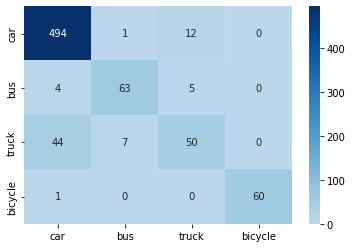

In [82]:
ax = sns.heatmap(C_Mat, annot=True, fmt='.0f', 
                 xticklabels= classes[1:], yticklabels= classes[1:], center = 150,
             cmap='Blues')
plt.show()

### Metrics

In [83]:
fo_results.print_report(classes=classes[1:])

              precision    recall  f1-score   support

         car       0.51      0.70      0.59       704
         bus       0.53      0.72      0.61        88
       truck       0.38      0.32      0.35       155
     bicycle       0.35      0.60      0.44       100

   micro avg       0.48      0.64      0.55      1047
   macro avg       0.44      0.59      0.50      1047
weighted avg       0.48      0.64      0.54      1047



### Overall micro-average metrics

In [95]:
print(f"overall mAP:{fo_results.mAP():.3f}")

overall mAP:0.266


In [91]:
for i,j in fo_results.metrics().items():
    print(f"overall {i} = {j:.2f}")

overall accuracy = 0.40
overall precision = 0.48
overall recall = 0.64
overall fscore = 0.55
overall support = 1047.00


### Prediction Examples

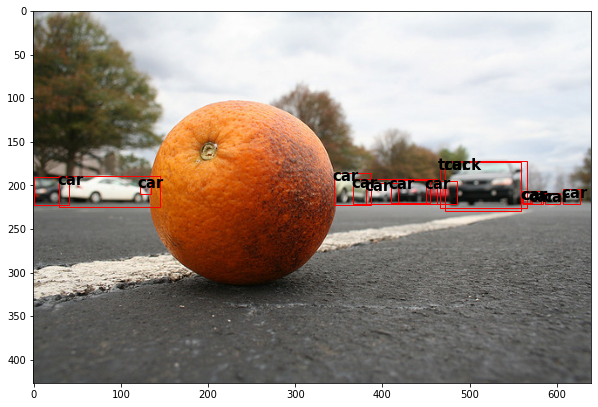

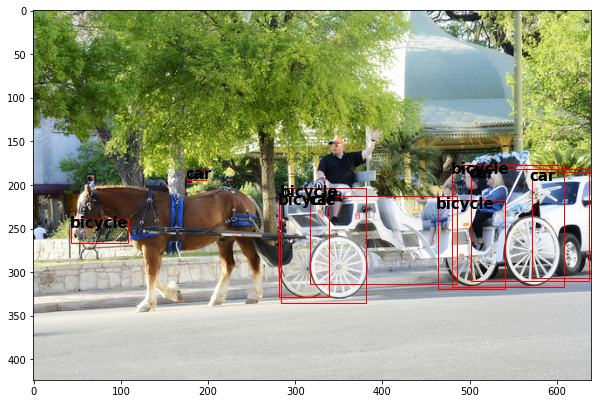

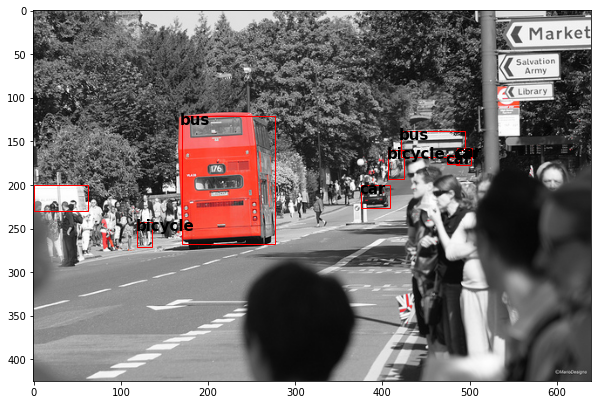

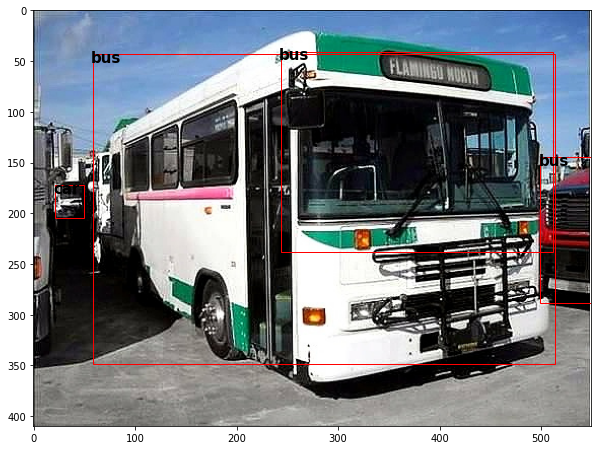

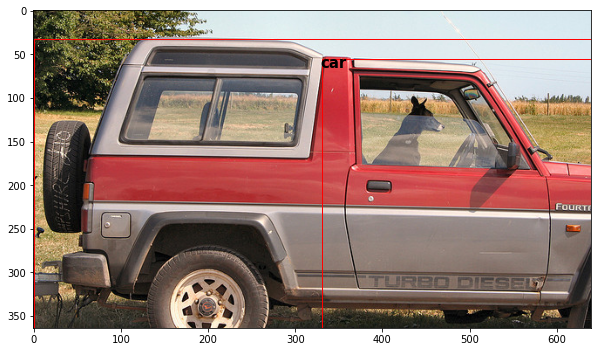

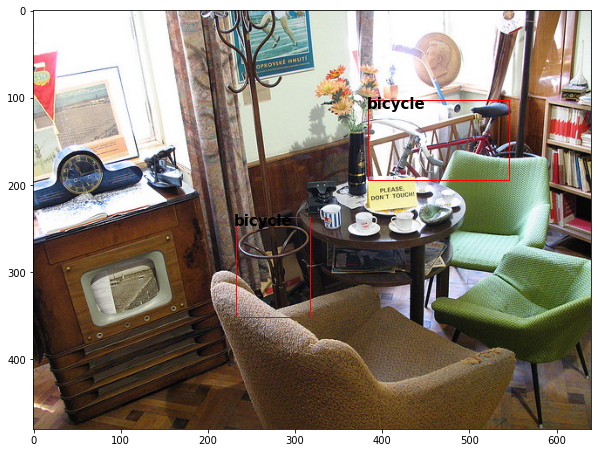

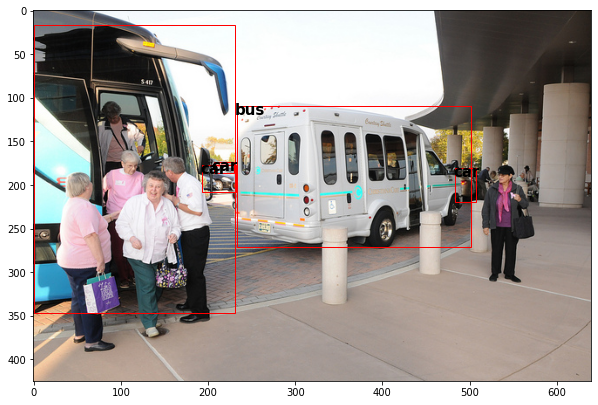

In [122]:
i = 0
for image, target in Valid_Ds:
    inpt = image.unsqueeze(0).to(device)
    preds = model(inpt)
    plot_image(image, preds[0], Valid_Ds)
    i+=1
    if i == 7:
        break

### References

1. Some parts from the Dataset, Training, Inference, evaluation and Metrics section are taken from the official Fiftyone tutorial for Object detection tutorial which can be found here:
https://colab.research.google.com/github/voxel51/fiftyone-examples/blob/master/examples/pytorch_detection_training.ipynb

2. The plot_image function is taken from https://www.kaggle.com/code/daniel601/pytorch-fasterrcnn

3. https://voxel51.com/docs/fiftyone/integrations/coco.html

4. https://voxel51.com/docs/fiftyone/tutorials/evaluate_detections.html